In [1]:
from model import Model
import perturbation as pb
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.datasets import fashion_mnist
from keras.utils import np_utils
import cv2

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [3]:
tf.reset_default_graph()

In [4]:
# Load data
(fr_train_images, fr_train_labels), \
(fr_test_images, fr_test_labels) = fashion_mnist.load_data()
mnist_raw = input_data.read_data_sets("./mnist/data/", one_hot=True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [5]:
dataset = "mnist" # mnist fashion
network = "cnn"     # cnn resnet

In [6]:
if dataset == "mnist":
  X_raw_train = mnist_raw.train.images
  Y_raw_train = mnist_raw.train.labels
  X_raw_test  = mnist_raw.test.images
  Y_raw_test  = mnist_raw.test.labels
elif dataset == "fashion":
  frx_train = fr_train_images.reshape(fr_train_images.shape[0], 28, 28, 1).astype('float32')
  fry_test  = fr_test_images.reshape(fr_test_images.shape[0], 28, 28, 1).astype('float32')
  X_raw_train  = frx_train/255
  Y_raw_train  = np_utils.to_categorical(fr_train_labels)
  X_raw_test   = fry_test/255
  Y_raw_test   = np_utils.to_categorical(fr_test_labels)
  num_examples = fr_train_images.shape[0]
  pattern      = np.reshape(pattern, (28, 28, 1))
  fpx_train    = np.zeros(X_raw_train.shape)
  fpx_test     = np.zeros(X_raw_test.shape)

  for i in range(0, fr_train_images.shape[0]):
    fpx_train[i] = X_raw_train[i] + pattern
  for i in range(0, fr_test_images.shape[0]):
    fpx_test[i] = X_raw_test[i] + pattern
  X_process_train = fpx_train
  Y_process_train = Y_raw_train
  X_process_test  = fpx_test
  Y_process_test  = Y_raw_test

In [7]:
# variables
X_r = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xr")
Y_r = tf.placeholder(tf.float32, [None, 10])
# X_p = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xp")
Y_p = tf.placeholder(tf.float32, [None, 10])

In [8]:
model = Model(10)
# generate perturbation according to the input
_, G_sample = pb.generator(X_r)

In [9]:
if network == "cnn":
  output_logits_real, output_real = model.basic_cnn(X_r)
  output_logits_fake, output_fake = model.basic_cnn(G_sample,reuse=True)
elif network == "resnet":
  output_logits_real, output_real = model.resnet20(X_r)
  output_logits_fake, output_fake = model.resnet20(G_sample,reuse=True)

In [10]:
# loss
alpha = 1.
beta = 1.
gama = 10.
loss_r = alpha * tf.reduce_mean(tf.reduce_sum(Y_r * output_real, -1))
loss_p = beta * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_logits_fake, labels=Y_p))
loss_d = gama * tf.reduce_mean(tf.square(X_r - G_sample))
loss_p_d =  tf.add(loss_p, loss_d)
total_loss = loss_r+loss_p+loss_d

In [11]:
# learning rate
global_step = tf.Variable(0, trainable=False)   
lr_decayed = tf.train.exponential_decay(0.001, global_step, 2*10000, 0.1, staircase=False)

In [12]:
# variable list
all_var = tf.all_variables()
g_vars = [var for var in all_var if 'generator' in var.name]
d_vars = [var for var in all_var if 'discriminator' in var.name]

Instructions for updating:
Please use tf.global_variables instead.


In [13]:
D_optimizer = tf.train.AdamOptimizer(learning_rate=lr_decayed).minimize(total_loss, var_list=[d_vars])
G_optimizer = tf.train.AdamOptimizer(learning_rate=lr_decayed).minimize(loss_p_d, var_list=[g_vars])

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [291]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 128
i = 0
D_loss = open('out/acc_loss/discriminator_loss.txt','a+')
G_loss = open('out/acc_loss/generator_loss.txt','a+')
for it in range(20000):
  if it % 2000 == 0:
    samples = sess.run(G_sample, feed_dict={X_r: X_raw_train[it].reshape(-1,28,28,1)})
    samples = (samples / 2 + 0.5)*255
    fig = plot(samples)
    plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
    cv2.imwrite('out/cv2_{}.png'.format(str(i).zfill(3)), samples.reshape(28,28,1))
    i += 1
    plt.close(fig)
  if dataset == "mnist":
    batch_xr, batch_yr = mnist_raw.train.next_batch(batch_size)
    # _, batch_yp = mnist_process.train.next_batch(batch_size)
    batch_yp = batch_yr.copy()
  elif dataset == "fashion":
    batch_xr = X_raw_train[i*128:(i+1)*128]
    batch_yr = Y_raw_train[i*128:(i+1)*128]
    # batch_xp = X_process_train[i*128:(i+1)*128]
    batch_yp = batch_yr.copy()
    
  batch_xr = batch_xr.reshape(-1, 28, 28, 1)
  # batch_xp = batch_xp.reshape(-1, 28, 28, 1)

  # train discriminator
  _, D_loss_curr = sess.run([D_optimizer, total_loss],
                            feed_dict={X_r: batch_xr,
                                       Y_r: batch_yr,
                                       Y_p: batch_yp})
  _, G_loss_curr = sess.run([G_optimizer, loss_p_d], feed_dict={X_r: batch_xr, Y_p: batch_yp})

  if it % 400 == 0:
    print('Iter: {}'.format(it))
    print('D loss: {:.4}'.format(D_loss_curr))
    print('G_loss: {:.4}'.format(G_loss_curr))
    print()
    D_loss.write(str(D_loss_curr)+'\n')
    G_loss.write(str(G_loss_curr)+'\n')

D_loss.close()
G_loss.close()

Iter: 0
D loss: 2.453
G_loss: 2.351

Iter: 400
D loss: 0.3543
G_loss: 0.1914

Iter: 800
D loss: 0.3111
G_loss: 0.1563

Iter: 1200
D loss: 0.1969
G_loss: 0.1382

Iter: 1600
D loss: 0.1889
G_loss: 0.09676

Iter: 2000
D loss: 0.2506
G_loss: 0.124

Iter: 2400
D loss: 0.1992
G_loss: 0.08369

Iter: 2800
D loss: 0.2038
G_loss: 0.06502

Iter: 3200
D loss: 0.2042
G_loss: 0.1365

Iter: 3600
D loss: 0.1744
G_loss: 0.04458

Iter: 4000
D loss: 0.1278
G_loss: 0.04788

Iter: 4400
D loss: 0.18
G_loss: 0.03988

Iter: 4800
D loss: 0.1228
G_loss: 0.04897

Iter: 5200
D loss: 0.1706
G_loss: 0.04785

Iter: 5600
D loss: 0.1371
G_loss: 0.03581

Iter: 6000
D loss: 0.1305
G_loss: 0.04168

Iter: 6400
D loss: 0.1048
G_loss: 0.04797

Iter: 6800
D loss: 0.1774
G_loss: 0.03709

Iter: 7200
D loss: 0.1757
G_loss: 0.03989

Iter: 7600
D loss: 0.1269
G_loss: 0.07778

Iter: 8000
D loss: 0.0973
G_loss: 0.06359

Iter: 8400
D loss: 0.1059
G_loss: 0.04121

Iter: 8800
D loss: 0.1578
G_loss: 0.04504

Iter: 9200
D loss: 0.1319
G

In [16]:
# calculate accuracy
correct_prediction = tf.equal(tf.argmax(output_fake, axis=-1), \
        tf.argmax(Y_p, axis=-1))
accuracy_fake = tf.reduce_mean(tf.cast(correct_prediction, "float"))

correct_prediction1 = tf.equal(tf.argmax(output_real, axis=-1), \
        tf.argmax(Y_p, axis=-1))
accuracy_real = tf.reduce_mean(tf.cast(correct_prediction1, "float"))
# test processed input
Accuracy_real = np.array([])
Accuracy_fake = np.array([])
for i in range(1000):
    #batch_xr, batch_yr = mnist_raw.train.next_batch(batch_size)
    #batch_xp, batch_yp = mnist_process.train.next_batch(batch_size)
    #batch_xr = batch_xr.reshape(-1, 28, 28, 1)
    #batch_xp = batch_xp.reshape(-1, 28, 28, 1)

  if dataset == "mnist":
    batch_xr, batch_yr = mnist_raw.train.next_batch(batch_size)
    # _, batch_yp = mnist_process.train.next_batch(batch_size)
    batch_yp = batch_yr.copy()
  elif dataset == "fashion":
    batch_xr = X_raw_train[i*128:(i+1)*128]
    batch_yr = Y_raw_train[i*128:(i+1)*128]
    # batch_xp = X_process_train[i*128:(i+1)*128]
    batch_yp = batch_yr.copy()
    
  batch_xr = batch_xr.reshape(-1, 28, 28, 1)
  # batch_xp = batch_xp.reshape(-1, 28, 28, 1)

  # train discriminator
  temp_acc, temp_acc_ = sess.run([accuracy_real,accuracy_fake],
                            feed_dict={X_r: batch_xr,
                                       Y_r: batch_yr,
                                       Y_p: batch_yp})
  #_, G_loss_curr = sess.run([G_optimizer, loss_p_d], feed_dict={X_r: batch_xr, Y_p: batch_yp})
  Accuracy_real = np.insert(Accuracy_real,0, temp_acc)
  Accuracy_fake = np.insert(Accuracy_fake,0, temp_acc_)
print('accuracy of real data: %.3f' % np.mean(Accuracy_real))
print('accuracy of fake data: %.3f' % np.mean(Accuracy_fake))

accuracy of real data: 0.104
accuracy of fake data: 0.999


In [269]:
NUM_CLASSES = 10
def step_fgsm(x, eps, logits):
  label = tf.argmax(logits,1)
  one_hot_label = tf.one_hot(label, NUM_CLASSES)
  cross_entropy = tf.losses.softmax_cross_entropy(one_hot_label,
                                                  logits,
                                                  label_smoothing=0.1,
                                                  weights=1.0)
  x_adv = x + eps*tf.sign(tf.gradients(cross_entropy,x)[0])
  x_adv = tf.clip_by_value(x_adv,-1.0,1.0)
  return tf.stop_gradient(x_adv)
 
def step_targeted_attack(x, eps, one_hot_target_class, logits):
  #one_hot_target_class = tf.one_hot(target, NUM_CLASSES)
  #print(one_hot_target_class,"\n\n")
  cross_entropy = tf.losses.softmax_cross_entropy(one_hot_target_class,
                                                  logits,
                                                  label_smoothing=0.1,
                                                  weights=1.0)
  x_adv = x - eps * tf.sign(tf.gradients(cross_entropy, x)[0])
  x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)
  return tf.stop_gradient(x_adv)

def step_ll_adversarial_images(x, eps, logits):
  least_likely_class = tf.argmin(logits, 1)
  one_hot_ll_class = tf.one_hot(least_likely_class, NUM_CLASSES)
  one_hot_ll_class = tf.reshape(one_hot_ll_class,[1,NUM_CLASSES])
  # This reuses the method described above
  return step_targeted_attack(x, eps, one_hot_ll_class, logits)

In [270]:
with tf.Session() as session:
#print(mnist_raw.train.images[0])
  target_class = tf.reshape(tf.one_hot(2,NUM_CLASSES),[1,NUM_CLASSES])
  out = session.run(target_class)
  print(out)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [283]:
softmax_tensor = sess.graph.get_tensor_by_name('discriminator/fc2/add:0')
image_tensor = sess.graph.get_tensor_by_name('xr:0')
target_class = tf.reshape(tf.one_hot(2,NUM_CLASSES),[1,NUM_CLASSES])

adv_image_tensor = step_targeted_attack(image_tensor, 0.007, target_class, softmax_tensor)
adv_image = mnist_raw.train.images[0].reshape(-1,28,28,1)
t = adv_image.copy()
adv_noise = np.zeros(t.shape)
for j in range(55000):
  adv_image = mnist_raw.train.images[j].reshape(-1,28,28,1)
  if j%2000==0:
    print("Iteration "+str(j))
  for i in range(10):
    #print("Iteration "+str(i))
    adv_image = sess.run(adv_image_tensor,{'xr:0': adv_image})
  adv_noise = np.concatenate((adv_noise, adv_image))
#plt.imshow(adv_image.reshape(-1,28))

Iteration 0
Iteration 2000
Iteration 4000
Iteration 6000
Iteration 8000
Iteration 10000
Iteration 12000
Iteration 14000
Iteration 16000
Iteration 18000
Iteration 20000
Iteration 22000
Iteration 24000
Iteration 26000
Iteration 28000
Iteration 30000
Iteration 32000
Iteration 34000
Iteration 36000
Iteration 38000
Iteration 40000
Iteration 42000
Iteration 44000
Iteration 46000
Iteration 48000
Iteration 50000
Iteration 52000
Iteration 54000


In [285]:
from PIL import Image

for i in range(54999):
  im = adv_noise[i+1].reshape(28,28)
  img= Image.fromarray(im*255)
  img = img.convert('RGB')
  img.save('out/adversarial/3/adv_%s.png'%i,'png')

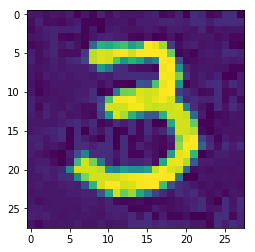

In [287]:
plt.imshow(adv_noise[54999].reshape(-1,28))
#print(mnist_raw.train.labels[3])
#plt.show()
#save_image(t,(-1,28,28,1),"original.jpg")

In [288]:
adv = tf.placeholder(tf.float32, [None, 28, 28, 1], name="adv")
output_logits_adv, output_adv = model.basic_cnn(adv, reuse=True)

correct_prediction2 = tf.equal(tf.argmax(output_adv, -1), \
        tf.argmax(target_class, -1))
accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, "float"))
print("test accuracy %g" %accuracy2.eval(session = sess,
      feed_dict = {
          adv:adv_noise}))

test accuracy 0.474719
